In [2]:
import sys
import json

from pathlib import Path
root = Path('..').resolve()
sys.path.insert(0, str(root))

from tqdm import tqdm
import torch
import torch.nn as nn
import lightning.pytorch
import matplotlib.pyplot as plt

import train_config as tc
import data_utils as du
import image_utility as iu
from lit_model import LitModel
from models import XceptionModel
from optimizers import adam
import iterative_training.iterative_training_utils as itu

Using device: cpu


/home/andrea/miniconda3/envs/polar-lows-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
max_tr_file_0 = root / 'max_translations' / 'max_translations_0.json'
max_tr_file_1 = root / 'max_translations' / 'max_translations_2.json'

In [4]:
with open(max_tr_file_0, 'r') as jf:
    maximum_translations_0 = json.load(jf)

In [5]:
with open(max_tr_file_1, 'r') as jf:
    maximum_translations_1 = json.load(jf)

In [6]:
itu.average_bounding_box_area(maximum_translations_0)

1319.530303030303

In [7]:
# Initialize sums for each direction
sums = {"up": 0, "down": 0, "left": 0, "right": 0}

# Iterate over all images and add the values to the respective direction sum
for image_data in maximum_translations_1.values():
    for direction in sums:
        sums[direction] += image_data[direction]

# Calculate averages
num_images = len(maximum_translations_1)
averages = {direction: total / num_images for direction, total in sums.items()}

# Print the averages
print(averages)

fractions = {direction: (average / 299) for direction, average in averages.items()}
print(fractions)

{'up': 200.24242424242425, 'down': 184.4431818181818, 'left': 188.1590909090909, 'right': 187.47727272727272}
{'up': 0.6697071044897132, 'down': 0.6168668288233505, 'left': 0.6292946184250532, 'right': 0.6270142900577683}


In [8]:
def calculate_transl_fraction(image_size, max_transl_dict):
    # Initialize sums for each direction
    sums = {"up": 0, "down": 0, "left": 0, "right": 0}
    
    # Iterate over all images and add the values to the respective direction sum
    for image_transl in max_transl_dict.values():
        for direction in sums:
            sums[direction] += image_transl[direction]
    
    # Calculate averages
    num_images = len(max_transl_dict)
    averages = {direction: total / num_images for direction, total in sums.items()}

    width, height = image_size
    fractions['up'] = averages['up'] / height
    fractions['down'] = averages['down'] / height
    fractions['left'] = averages['left'] / width
    fractions['right'] = averages['right'] / width
    return fractions

In [12]:
print(itu.calculate_max_transl_fractions(maximum_translations_1, (299, 299)))

{'up': 0.6697071044897132, 'down': 0.6168668288233505, 'left': 0.6292946184250532, 'right': 0.6270142900577683}


In [96]:
itu.average_bounding_box_area(maximum_translations_1)

8242.10606060606

In [9]:
torch_model_0 = XceptionModel(num_classes=2)
torch_model_1 = XceptionModel(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = adam(torch_model_0)
lit_model_0 = LitModel.load_from_checkpoint(root / 'checkpoints' / 'base_model.ckpt', model=torch_model_0, criterion=criterion, optimizer=optimizer)
lit_model_1 = LitModel.load_from_checkpoint(root / 'checkpoints' / 'best-checkpoint-v5.ckpt', model=torch_model_1, criterion=criterion, optimizer=optimizer)

/home/andrea/Documents/Thesis/polar-lows-detection-forecasting-deep-learning/data/train/pos/846bf5_20151024T164034_20151024T164234_mos_rgb.png
Model 0 -- Predicted: pos. Actual: pos
Model 1 -- Predicted: pos. Actual: pos


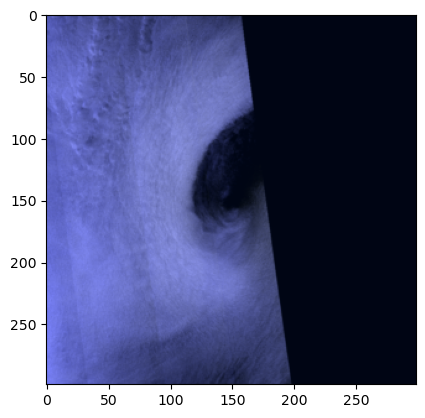

In [10]:
image_path = du.pick_random_image(root / 'data' / 'train', 'pos')
# image_path = '/home/andrea/Documents/Thesis/polar-lows-detection-forecasting-deep-learning/data/train/pos/2efdb4_20181201T174136_20181201T174316_mos_rgb.png'
print(image_path)
image = du.load_and_transform_image(image_path, tc.transform_prep, tc.device)

# Predict image class
lit_model_0.eval()
pred = torch.argmax(lit_model_0(image), dim=1).item()
print(f'Model 0 -- Predicted: {"pos" if pred==1 else "neg"}. Actual: pos')

lit_model_1.eval()
pred = torch.argmax(lit_model_1(image), dim=1).item()
print(f'Model 1 -- Predicted: {"pos" if pred==1 else "neg"}. Actual: pos')

# Visualize the image
plt.imshow(iu.normalize_image(iu.convert_to_np_array(image)))
plt.show()

In [11]:
import iterative_training.iterative_training_utils as itu

resolution = 1
max_translations_0 = itu.find_maximum_translations(lit_model_0, image, resolution=resolution)
print(f'Model 0 -- max_translations: {max_translations_0}')
max_translations_1 = itu.find_maximum_translations(lit_model_1, image, resolution=resolution)
print(f'Model 1 -- max_translations: {max_translations_1}')

Model 0 -- max_translations: {'up': 169, 'down': 169, 'left': 133, 'right': 168}
Model 1 -- max_translations: {'up': 193, 'down': 198, 'left': 145, 'right': 177}


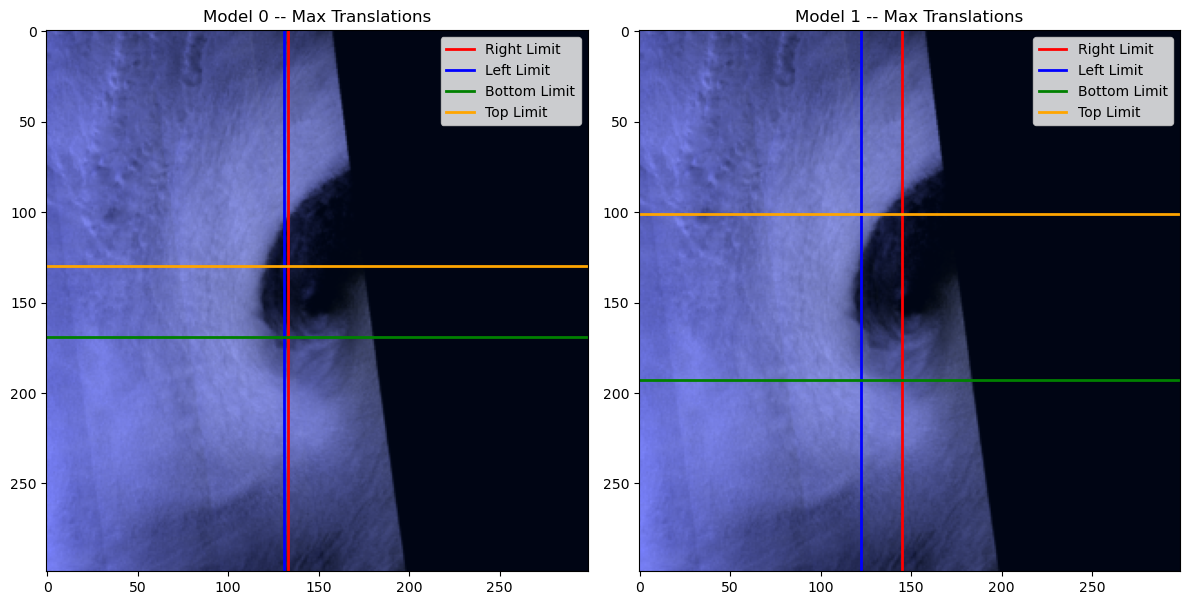

In [12]:
def plot_max_translations(ax, max_translations, title):
    ax.imshow(iu.normalize_image(iu.convert_to_np_array(image)))
    ax.axvline(x=max_translations['left'], color='red', linewidth=2, label='Right Limit')
    ax.axvline(x=299-max_translations['right'], color='blue', linewidth=2, label='Left Limit')
    ax.axhline(y=max_translations['up'], color='green', linewidth=2, label='Bottom Limit')
    ax.axhline(y=299-max_translations['down'], color='orange', linewidth=2, label='Top Limit')
    ax.legend()
    ax.set_title(title)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Model 0
plot_max_translations(axes[0], max_translations_0, "Model 0 -- Max Translations")

# Plot for Model 1
plot_max_translations(axes[1], max_translations_1, "Model 1 -- Max Translations")

# Adjust layout and show
plt.tight_layout()
plt.show()
